**Nome:**Laura\
**Cognome**: Nembrini \
**Matricola:** 819059

# ASSIGNMENT 1

In [ ]:
import os
import numpy as np
from time import time
from scipy.io import wavfile as wav

import matplotlib.pyplot as plt
import IPython.display as ipd

# Classification tools
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# File management
from google.colab import drive
import tarfile
from shutil import copyfile

# Advanced audio features
import librosa
import librosa.display as lid
from sklearn.preprocessing import scale

## FILE READING

In [ ]:
# Link Google Drive account, transfer dataset, and extract files
drive.mount('/content/gdrive')
copyfile('gdrive/MyDrive/DATA SCIENCE/SECONDO ANNO/DIGITAL SIGNAL AND IMAGE MANAGEMENT/recordings.tar', 'recordings.tar')
tar = tarfile.open('recordings.tar')
tar.extractall()
tar.close()



Mounted at /content/gdrive


## DATA LOADER

Viene effettuata tramite la funzione *load_data* l'estrazione delle labels, la suddivisione del dataset in train e test sets e la normalizzazione delle tracce audio.




In [ ]:
# Placecholder for feature extractor
def identity(input):
    return input

# Data loader
def load_data(feature_extractor=identity, normalize=False):

    labels = []
    features = []

    for f in sorted(os.listdir('./recordings')):
        if f.endswith('.wav'):
            _, signal = wav.read('./recordings/' + f)
            cur_features = feature_extractor(signal)
            features.append(cur_features)

            
            label = f.split('_')[0]
            labels.append(label)

 
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, random_state=1)

    if normalize:
        eps = 0.001
        X_train = np.array(X_train)
        X_train_mean = X_train.mean(axis=0)
        X_train_std = X_train.std(axis=0)
        X_train = (X_train - X_train_mean + eps)/(X_train_std + eps)
        X_train = [row for row in X_train]

        X_test = [row for row in (np.array(X_test) - X_train_mean + eps)/(X_train_std + eps)]

    return X_train, X_test, y_train, y_test

## CREAZIONE FEATURES
Creazione di 6 differenti funzioni di feature extraction (deviazione standard, media, media assoluta, durata, energia e zero crossing rate). \
**Z**ero **C**rossing **R**ate è la velocità di cambio di segno del segnale durante il frame. In altre parole, è il numero di volte in cui il segnale cambia valore, da positivo a negativo e viceversa, diviso per la lunghezza del frame.

In [ ]:
def crop(input, size=100)
    output = input[0:min(size, input.shape[0])]
    output = np.concatenate((output, np.zeros(size-output.shape[0])))
    return output

In [ ]:
def sdev(input):
    return np.std(input, keepdims=True)

In [ ]:
def avg(input):
    return np.mean(input, keepdims=True)

def aavg(input):
    return np.mean(np.abs(input), keepdims=True)

In [ ]:
def duration(input):
    return input.shape

def energy(input):
    return np.sum((input*1.0)**2, keepdims=True)

In [ ]:
def zcr(input):
  b = np.diff(np.sign(input))
  count = 0
  for i in range(0, len(b)):
    if np.sign(b[i]) != 0:
      count += +1
      c = np.array(int(count),ndmin=1)  
  return(c)


### Funzioni per concatenare le features create

Concatenazione **senza ZCR**

In [ ]:
def combo(input):
    return np.concatenate((aavg(input),sdev(input),duration(input),energy(input)))

Concatenazione **con ZCR**

In [ ]:
def combo_zcr(input):
    return np.concatenate((aavg(input),sdev(input),duration(input),energy(input), zcr(input)))


## CARICAMENTO DATI E DIVISIONE TRA TRAIN E TEST



Caricamento e divisione **senza ZCR**

In [ ]:
X_train, X_test, y_train, y_test = load_data(feature_extractor=combo, normalize=True)

print("Il training set è composto da", len(X_train), "tracce audio,con cardinalità pari a", len(X_train[0][:100]))
print("Il test set è composto da", len(X_test), "tracce audio, con cardinalità pari a", len(X_test[0]))

Il training set è composto da 1350 tracce audio,con cardinalità pari a 4
Il test set è composto da 150 tracce audio, con cardinalità pari a 4


Caricamento e divisione **con ZCR**

In [ ]:
X_train_z, X_test_z, y_train_z, y_test_z = load_data(feature_extractor = combo_zcr, normalize=True)

In [ ]:
print("Il training set è composto da", len(X_train_z), "tracce audio, con cardinalità pari a", len(X_train_z[0]))
print("Il test set è composto da", len(X_test_z), "tracce audio, con cardinalità pari a", len(X_test_z[0]))

Il training set è composto da 1350 tracce audio, con cardinalità pari a 5
Il test set è composto da 150 tracce audio, con cardinalità pari a 5


## ADDESTRAMENTO MODELLI
Il modello utilizzato per la classificazione è SVC, i cui iper-parametri vengono ottimizzati attraverso il metodo GridSearch con 2-cross validation.

##Modello senza ZCR

In [ ]:
# Caricamento dati
X_train, X_test, y_train, y_test = load_data(feature_extractor=combo, normalize=True)

In [ ]:
param_grid = {'C': [1e2, 5e2, 1e3],
          'gamma': [0.005, 0.01, 0.1, 0.5, 1.0], }

clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=2)


t0 = time()
clf = clf.fit(X_train, y_train)
print('Training completed in %0.3fs' % (time() - t0))

Training completed in 4.458s


In [ ]:
print('Miglior combinazione di parametri:')
print(' C: '+str(clf.best_estimator_.C))
print(' gamma: '+str(clf.best_estimator_.gamma))

Miglior combinazione di parametri:
 C: 1000.0
 gamma: 0.5


### Modello con ZCR

In [ ]:
param_grid = {'C': [1e2, 5e2, 1e3],
          'gamma': [0.005, 0.01, 0.1, 0.5, 1.0], }
clf_z = GridSearchCV(SVC(kernel = 'rbf',
                       class_weight = 'balanced'),
                   param_grid, cv = 2)

#Training
t0 = time()
clf_z = clf_z.fit(X_train_z, y_train_z)
print('Training completed in %0.3fs' % (time() - t0))
print("\n")
print('Miglior combinazione di parametri:')
print(' C: '+str(clf_z.best_estimator_.C))
print(' gamma: '+str(clf_z.best_estimator_.gamma))

Training completed in 3.005s


Miglior combinazione di parametri:
 C: 1000.0
 gamma: 0.1


## CONFRONTO RISULTATI
### Performance sul test set senza ZCR

Classification report:
              precision    recall  f1-score   support

           0       0.58      0.65      0.61        17
           1       0.33      0.40      0.36        10
           2       0.28      0.33      0.30        15
           3       0.53      0.42      0.47        19
           4       0.36      0.45      0.40        11
           5       0.44      0.29      0.35        14
           6       0.79      0.79      0.79        14
           7       0.80      0.42      0.55        19
           8       0.35      0.41      0.38        17
           9       0.32      0.43      0.36        14

    accuracy                           0.46       150
   macro avg       0.48      0.46      0.46       150
weighted avg       0.49      0.46      0.47       150

Confusion matrix:
[[11  0  0  0  0  0  0  0  0  6]
 [ 0  4  2  2  0  1  0  0  1  0]
 [ 2  1  5  3  0  0  0  0  2  2]
 [ 0  3  7  8  0  0  0  0  0  1]
 [ 1  1  1  1  5  2  0  0  0  0]
 [ 1  0  0  1  4  4  1  0  2  1]
 [

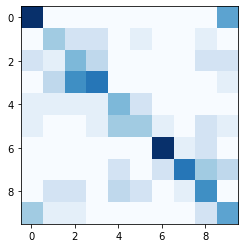

In [ ]:
# Test
y_pred = clf.predict(X_test)

# Classificaiton report
print('Classification report:')
print(classification_report(y_test, y_pred))

# Confusion matrix
print('Confusion matrix:')
cm = confusion_matrix(y_test, y_pred)
print(cm)
plt.imshow(cm, cmap=plt.cm.Blues)

### Performance sul test set con ZCR

              precision    recall  f1-score   support

           0       0.74      0.82      0.78        17
           1       0.50      0.80      0.62        10
           2       0.60      0.60      0.60        15
           3       0.67      0.53      0.59        19
           4       0.46      0.55      0.50        11
           5       0.44      0.57      0.50        14
           6       0.93      0.93      0.93        14
           7       0.67      0.32      0.43        19
           8       0.61      0.65      0.63        17
           9       0.69      0.64      0.67        14

    accuracy                           0.63       150
   macro avg       0.63      0.64      0.62       150
weighted avg       0.64      0.63      0.62       150

[[14  0  1  0  0  0  0  0  0  2]
 [ 0  8  0  1  0  1  0  0  0  0]
 [ 1  0  9  1  0  1  1  0  2  0]
 [ 0  2  3 10  1  3  0  0  0  0]
 [ 1  2  1  1  6  0  0  0  0  0]
 [ 0  1  0  0  1  8  0  3  0  1]
 [ 0  0  0  0  0  0 13  0  1  0]
 [ 1  1  0

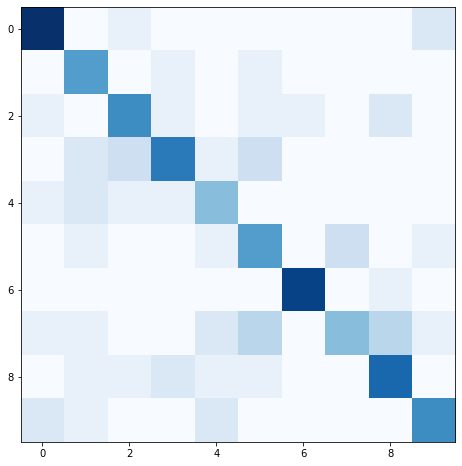

In [ ]:
#Test
y_pred_z = clf_z.predict(X_test_z) 

#Report della Classificazione
print(classification_report(y_test_z,
                            y_pred_z))

#Matrice di Confusione
print(confusion_matrix(y_test_z,
                       y_pred_z))      

plt.figure(figsize = (12, 8))
plt.imshow(confusion_matrix(y_test_z,
                            y_pred_z),
           cmap = plt.cm.Blues)



## Conclusione

ZCR migliora i risultati della classificazione, infatti l'accuratezza passa da 0,48 (svm senza zcr) a 0,63. Ciò significa che il segnale può essere distinto dal numero di zero-crossing.